Histopathologic Cancer Detection




In [ ]:
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, preprocessing
from google.colab import files

The cell below will promt you for a kaggle.json file. This file is needed for the Kaggle API.
For more information on how to download your own kaggle.json file, please see:
https://www.kaggle.com/docs/api

In [ ]:
#this will prompt you to upload the kaggle.json
files.upload()  

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"timomarmooren","key":"3faa9098cc7ca6d76d3804bc9f4bb31b"}'}

# Downloading data

The cell below will install the Kaggle package and move kaggle.json to the appropriate folder.

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

     |████████████████████████████████| 61kB 3.3MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=6772c3284f87c91c137b537bb346ae8c98733855e6b52bd92776bfae32932c71
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
kaggle.json


The cell below downloads and unzips the data

In [ ]:
!kaggle competitions download -c histopathologic-cancer-detection
!unzip histopathologic-cancer-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d

# Loading data

Load train_labels.csv and image id's to their respective label.

In [ ]:
labels_csv = pd.read_csv('train_labels.csv')
id2label = dict(zip(labels_csv.id, labels_csv.label))

Get the filepaths of all the images and divide them into training and validation data.

In [ ]:
# get filepaths of all the images
file_paths = glob.glob('train/*.tif')
# split the filepaths into train and validation data
train_paths, val_paths = train_test_split(file_paths, test_size=0.3, random_state=1)

Prepare training and validation data. Images are resized from 96x96 to 48x48 due to memory constraints.

Inspiration was taken from NN_gtsrb notebook, but we hoped to make it more memory-effiecient by initializing a Numpy-zeros array, rather than converting a regular Python list to a Numpy array. We would love to hear your feedback on whether this makes a difference.

In [ ]:
def crop_ROI(image):
    """Crops image to region of interest. """
    x1, y1 = 32, 32
    x2, y2 = 64, 64

    return image[1:(y2 + 1), 1:(x2 + 1)]

def load_data(image_paths):
    """
    Prepares data for training or validation.

    Arguments: File paths of relevant images as list.

    Returns: A tuple containing:
        - Four dimensional Numpy array containing all the images (ready for training).
        - Targets
    """
    target_list = []
    image_list  = np.zeros((len(image_paths), 32, 32, 3))

    for index, image_path in enumerate(image_paths):
            # image id is equal to the filename
            id = image_path[6:-4]
            # get relevant label
            target = id2label[id]
            # add target to the list
            target_list.append(target)
            # add image to the list
            image_list[index] = cv2.resize(cv2.imread(image_path), (32, 32))

    # convert to one-hot encoding
    targets = tf.keras.utils.to_categorical(target_list)

    return (image_list, targets)


train_images, train_labels = load_data(train_paths)
val_images, val_labels = load_data(val_paths)

print(f'Training images loaded: {train_images.shape}')
print(f'Training labels loaded: {train_labels.shape}')
print(f'Testing images loaded: {val_images.shape}')
print(f'Testing labels loaded: {val_labels.shape}')

Training images loaded: (154017, 32, 32, 3)
Training labels loaded: (154017, 2)
Testing images loaded: (66008, 32, 32, 3)
Testing labels loaded: (66008, 2)


Source of code below: CNN_gtsrb notebook.
We added the recall metric, and the option to change the learning rate & batch size.




In [ ]:
def train_and_evaluate(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=20, augment={}, l_rate=0.001, batch_size=None):
    """
    Trains and evaluates a model based on training and testing data, and their respective labels.
    Preprocessing and data augmentation can be added trough their respective arguments.
    """
    opt = tf.keras.optimizers.Adam(learning_rate=l_rate)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(train_x)

    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y), batch_size=batch_size)

    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    for i, metric in enumerate(['loss', 'accuracy']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

    print(f"Validation Accuracy: {model.evaluate(val_gen.flow(val_x, val_y))[1]}")

# Model 1: Base model


For our base model, we made a simple convolutional neural network with the following architecture:

- 2 convolutional and max pooling layers
- 1 flatten layer
- 1 hidden layer
- 1 output layer

## 1a: Base model with learning rate = 0.001


Epoch 1/20
4814/4814 [==============================] - 83s 17ms/step - loss: 0.6835 - accuracy: 0.7753 - val_loss: 0.4467 - val_accuracy: 0.7971
Epoch 2/20
4814/4814 [==============================] - 83s 17ms/step - loss: 0.4396 - accuracy: 0.8016 - val_loss: 0.4116 - val_accuracy: 0.8144
Epoch 3/20
4814/4814 [==============================] - 81s 17ms/step - loss: 0.3996 - accuracy: 0.8232 - val_loss: 0.4065 - val_accuracy: 0.8185
Epoch 4/20
4814/4814 [==============================] - 82s 17ms/step - loss: 0.3778 - accuracy: 0.8338 - val_loss: 0.3995 - val_accuracy: 0.8242
Epoch 5/20
4814/4814 [==============================] - 82s 17ms/step - loss: 0.3616 - accuracy: 0.8411 - val_loss: 0.3819 - val_accuracy: 0.8319
Epoch 6/20
4814/4814 [==============================] - 82s 17ms/step - loss: 0.3506 - accuracy: 0.8469 - val_loss: 0.3634 - val_accuracy: 0.8410
Epoch 7/20
4814/4814 [==============================] - 81s 17ms/step - loss: 0.3419 - accuracy: 0.8519 - val_loss: 0.3758 -

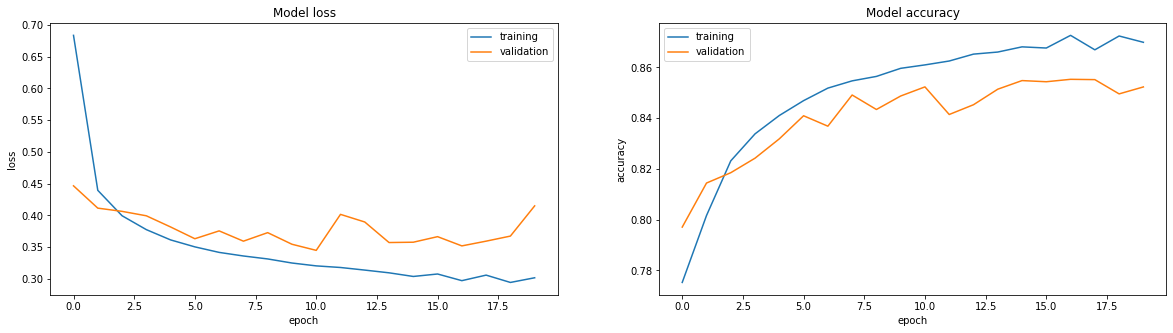

2063/2063 [==============================] - 9s 4ms/step - loss: 0.4151 - accuracy: 0.8523
Validation Accuracy: 0.8523209095001221


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels)

**Analysis of the graph above (Baseline model):**

The graph for our baseline model looks very promising, as both the training and the testing accuracy are increasing on a similar scale. 

One thing we found odd is that the validation data is fluctuating quite a bit. We aim to solve this in future models.

Although the training and validation accuracy is increasing in the first 20 epochs, the slope of both lines becomes rather flat. In order to increase the speed of learning, we will preprocess the data in model 2. We hope that this will make the training accuracy line steeper by increasing the gain in accuracy per epoch.

## 1b: Base model (learning rate = 0.01)


In [ ]:
# base model with different learning rate
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, l_rate=0.01)

**Analysis of graph above (Baseline model wiht learning rate = 0.01):**

Increasing the learning rate from 0.001 to 0.01 is definitely not an improvement on the previous model. It looks like the algorithm is diverging rather than converging. For now, we will leave the learning rate at 0.001 and try other adjustments of the CNN.

# Model 2: Preprocessing



As an attempt to make the network learn faster, we applied featurewise center and featurewise standard normalization to the input images.

## 2a: Preprocessing (input = 32x32)

Epoch 1/20
4814/4814 [==============================] - 81s 11ms/step - loss: 0.4443 - accuracy: 0.7973 - val_loss: 0.3894 - val_accuracy: 0.8269
Epoch 2/20
4814/4814 [==============================] - 53s 11ms/step - loss: 0.3900 - accuracy: 0.8263 - val_loss: 0.3732 - val_accuracy: 0.8360
Epoch 3/20
4814/4814 [==============================] - 52s 11ms/step - loss: 0.3676 - accuracy: 0.8378 - val_loss: 0.3764 - val_accuracy: 0.8398
Epoch 4/20
4814/4814 [==============================] - 52s 11ms/step - loss: 0.3454 - accuracy: 0.8496 - val_loss: 0.3441 - val_accuracy: 0.8502
Epoch 5/20
4814/4814 [==============================] - 53s 11ms/step - loss: 0.3298 - accuracy: 0.8566 - val_loss: 0.3571 - val_accuracy: 0.8481
Epoch 6/20
4814/4814 [==============================] - 53s 11ms/step - loss: 0.3152 - accuracy: 0.8632 - val_loss: 0.3394 - val_accuracy: 0.8529
Epoch 7/20
4814/4814 [==============================] - 52s 11ms/step - loss: 0.3010 - accuracy: 0.8707 - val_loss: 0.3416 -

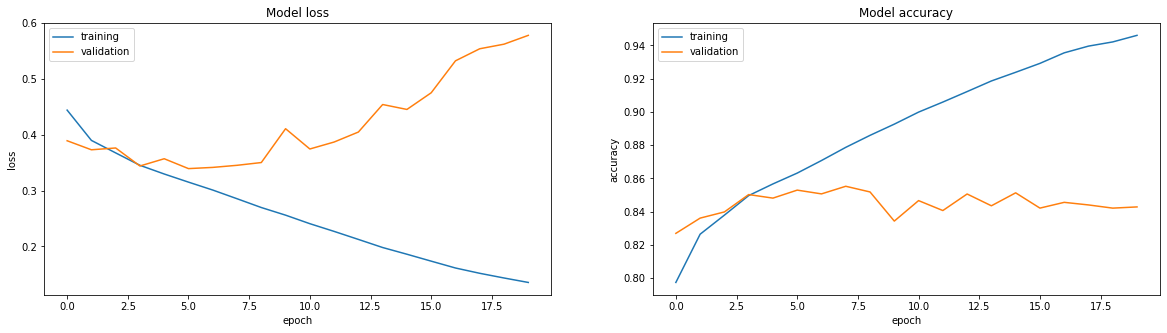

2063/2063 [==============================] - 10s 5ms/step - loss: 0.5782 - accuracy: 0.8428
Validation Accuracy: 0.8427766561508179


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True})

## 2b: Preprocessing (input = 48x48)

Epoch 1/20
4814/4814 [==============================] - 608s 126ms/step - loss: 0.4545 - accuracy: 0.7939 - val_loss: 0.5021 - val_accuracy: 0.7670
Epoch 2/20
4814/4814 [==============================] - 314s 65ms/step - loss: 0.3893 - accuracy: 0.8274 - val_loss: 0.3676 - val_accuracy: 0.8414
Epoch 3/20
4814/4814 [==============================] - 296s 61ms/step - loss: 0.3533 - accuracy: 0.8451 - val_loss: 0.3493 - val_accuracy: 0.8463
Epoch 4/20
4814/4814 [==============================] - 328s 68ms/step - loss: 0.3326 - accuracy: 0.8564 - val_loss: 0.4057 - val_accuracy: 0.8218
Epoch 5/20
4814/4814 [==============================] - 296s 61ms/step - loss: 0.3190 - accuracy: 0.8630 - val_loss: 0.3329 - val_accuracy: 0.8564
Epoch 6/20
4814/4814 [==============================] - 285s 59ms/step - loss: 0.3015 - accuracy: 0.8707 - val_loss: 0.3398 - val_accuracy: 0.8575
Epoch 7/20
4814/4814 [==============================] - 285s 59ms/step - loss: 0.2883 - accuracy: 0.8776 - val_loss: 

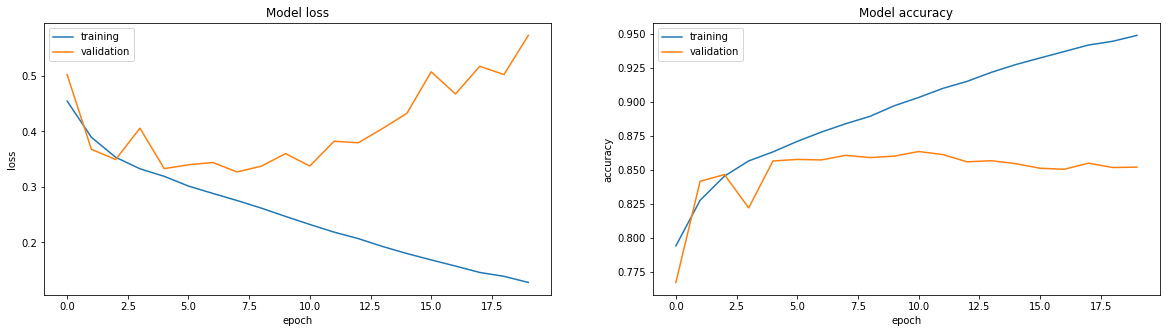

2063/2063 [==============================] - 10s 5ms/step - loss: 0.5728 - accuracy: 0.8518
Validation Accuracy: 0.8518210053443909


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True})

**Analysis of above graph (Preprocessing):**

Thanks to the normalization of the input data, the network was able to learn much quicker. This can be seen by the rapid increase in training accuracy as compared to the previous model. 

However, the validation accuracy reaches a plateau at some point, while the training data increases steadily. This is a sign that the model is overfitting to the training data. The overfitting starts around epoch 3 (as seen by the naked eye).



---





# Model 3: Dropout

In order to counteract the overfitting seen in the last model, we will add dropout to the network to increase robustness of the network.


## 3a: Dropout (input = 32x32)

Epoch 1/30
4814/4814 [==============================] - 29s 6ms/step - loss: 0.4625 - accuracy: 0.7898 - val_loss: 0.4119 - val_accuracy: 0.8146
Epoch 2/30
4814/4814 [==============================] - 29s 6ms/step - loss: 0.4121 - accuracy: 0.8183 - val_loss: 0.3919 - val_accuracy: 0.8275
Epoch 3/30
4814/4814 [==============================] - 29s 6ms/step - loss: 0.3924 - accuracy: 0.8279 - val_loss: 0.3636 - val_accuracy: 0.8401
Epoch 4/30
4814/4814 [==============================] - 28s 6ms/step - loss: 0.3795 - accuracy: 0.8349 - val_loss: 0.3881 - val_accuracy: 0.8259
Epoch 5/30
4814/4814 [==============================] - 29s 6ms/step - loss: 0.3726 - accuracy: 0.8393 - val_loss: 0.3748 - val_accuracy: 0.8300
Epoch 6/30
4814/4814 [==============================] - 29s 6ms/step - loss: 0.3664 - accuracy: 0.8422 - val_loss: 0.3441 - val_accuracy: 0.8534
Epoch 7/30
4814/4814 [==============================] - 29s 6ms/step - loss: 0.3631 - accuracy: 0.8428 - val_loss: 0.3911 - val_ac

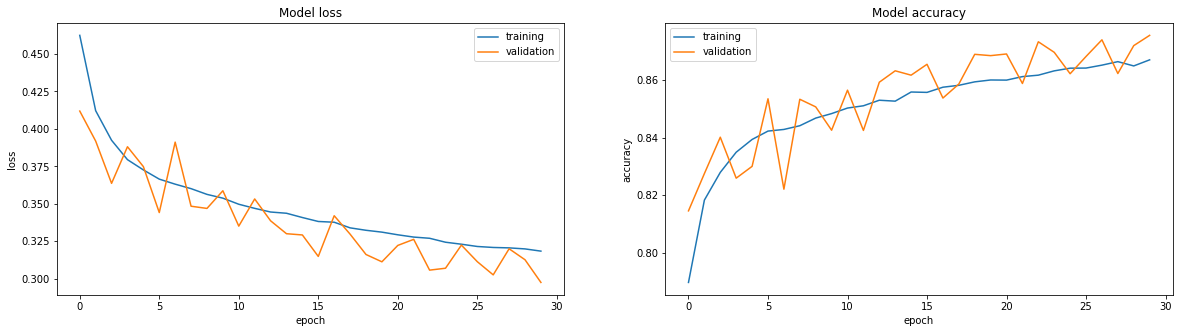

2063/2063 [==============================] - 8s 4ms/step - loss: 0.2974 - accuracy: 0.8754
Validation Accuracy: 0.8754242062568665


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
#added
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
# added
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, epochs=50, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}) 

## 3b: Dropout (input = 48x48)

Epoch 1/30
4814/4814 [==============================] - 109s 22ms/step - loss: 0.4661 - accuracy: 0.7919 - val_loss: 0.4679 - val_accuracy: 0.7990
Epoch 2/30
4814/4814 [==============================] - 109s 23ms/step - loss: 0.4080 - accuracy: 0.8209 - val_loss: 0.4586 - val_accuracy: 0.8039
Epoch 3/30
4814/4814 [==============================] - 110s 23ms/step - loss: 0.3865 - accuracy: 0.8329 - val_loss: 0.3987 - val_accuracy: 0.8326
Epoch 4/30
4814/4814 [==============================] - 109s 23ms/step - loss: 0.3719 - accuracy: 0.8393 - val_loss: 0.3906 - val_accuracy: 0.8298
Epoch 5/30
4814/4814 [==============================] - 109s 23ms/step - loss: 0.3627 - accuracy: 0.8430 - val_loss: 0.3660 - val_accuracy: 0.8450
Epoch 6/30
4814/4814 [==============================] - 109s 23ms/step - loss: 0.3553 - accuracy: 0.8466 - val_loss: 0.4056 - val_accuracy: 0.8153
Epoch 7/30
4814/4814 [==============================] - 109s 23ms/step - loss: 0.3517 - accuracy: 0.8490 - val_loss: 0

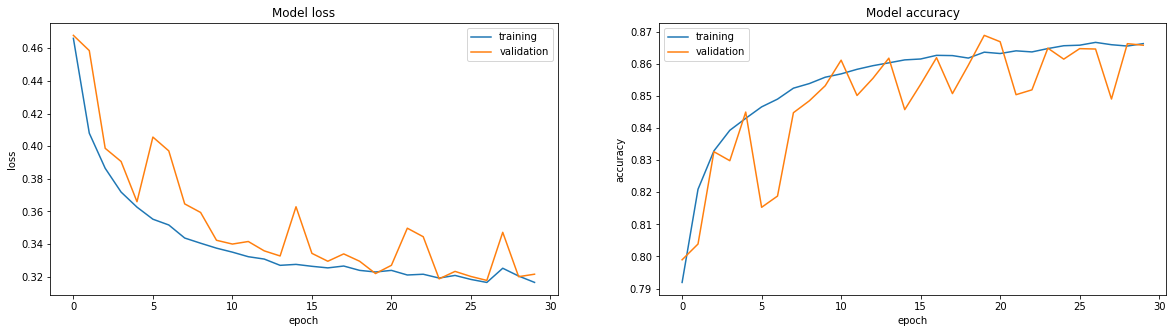

2063/2063 [==============================] - 10s 5ms/step - loss: 0.3216 - accuracy: 0.8658
Validation Accuracy: 0.865788996219635


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 3)))
model.add(layers.MaxPooling2D((2, 2)))
# added
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
# added
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
# added
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, epochs=30, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}) 

**Analysis of the graph above (Dropout):**

In correspondance with our hypothesis, the validation and training accuracy are roughly on the same line and scale again.

# Model 4: Deeper network
Now that we solved overfitting in the previous model, we will make an attempt to make the network deeper.

## 4a: Deeper network (input = 32x32)


Epoch 1/50
4814/4814 [==============================] - 36s 7ms/step - loss: 0.4528 - accuracy: 0.7941 - val_loss: 0.4081 - val_accuracy: 0.8113
Epoch 2/50
4814/4814 [==============================] - 35s 7ms/step - loss: 0.4023 - accuracy: 0.8229 - val_loss: 0.4066 - val_accuracy: 0.8183
Epoch 3/50
4814/4814 [==============================] - 35s 7ms/step - loss: 0.3846 - accuracy: 0.8322 - val_loss: 0.3922 - val_accuracy: 0.8214
Epoch 4/50
4814/4814 [==============================] - 35s 7ms/step - loss: 0.3730 - accuracy: 0.8394 - val_loss: 0.3624 - val_accuracy: 0.8424
Epoch 5/50
4814/4814 [==============================] - 36s 7ms/step - loss: 0.3665 - accuracy: 0.8421 - val_loss: 0.3553 - val_accuracy: 0.8432
Epoch 6/50
4814/4814 [==============================] - 36s 7ms/step - loss: 0.3615 - accuracy: 0.8451 - val_loss: 0.3412 - val_accuracy: 0.8485
Epoch 7/50
4814/4814 [==============================] - 35s 7ms/step - loss: 0.3583 - accuracy: 0.8462 - val_loss: 0.3388 - val_ac

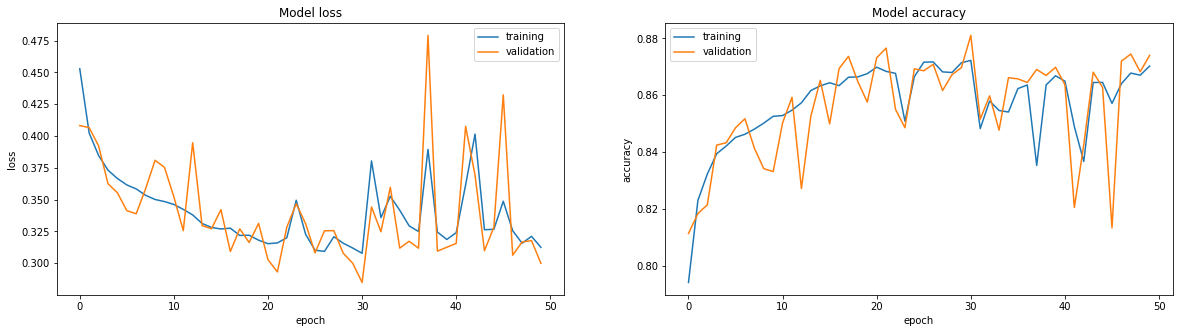

2063/2063 [==============================] - 9s 4ms/step - loss: 0.2998 - accuracy: 0.8740
Validation Accuracy: 0.8740152716636658


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=50) 

## 4b: Deeper network (input = 48x48)


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=40) 

Epoch 1/40
4814/4814 [==============================] - 1026s 213ms/step - loss: 0.4503 - accuracy: 0.7958 - val_loss: 0.4160 - val_accuracy: 0.8039
Epoch 2/40
4814/4814 [==============================] - 508s 105ms/step - loss: 0.3851 - accuracy: 0.8306 - val_loss: 0.3687 - val_accuracy: 0.8376
Epoch 3/40
4814/4814 [==============================] - 501s 104ms/step - loss: 0.3651 - accuracy: 0.8409 - val_loss: 0.3480 - val_accuracy: 0.8441
Epoch 4/40
4814/4814 [==============================] - 509s 106ms/step - loss: 0.3479 - accuracy: 0.8500 - val_loss: 0.3448 - val_accuracy: 0.8501
Epoch 5/40
4814/4814 [==============================] - 492s 102ms/step - loss: 0.3387 - accuracy: 0.8554 - val_loss: 0.3007 - val_accuracy: 0.8724
Epoch 6/40
4814/4814 [==============================] - 497s 103ms/step - loss: 0.3298 - accuracy: 0.8601 - val_loss: 0.3220 - val_accuracy: 0.8585
Epoch 7/40
4814/4814 [==============================] - 488s 101ms/step - loss: 0.3246 - accuracy: 0.8629 - val

KeyboardInterrupt: ignored

**Analysis of graph above (Deeper network)**

The lines of both the training and validation accuracy look pretty messy from a certain point (around epoch=20). 


# Model 5: Batch normalization

We decided to add batch normalization to the previous network to counteract the problem of  the training and validation accuracy fluctuating strongly after epoch 20.

## 5a: Batch normalization

Epoch 1/50
4814/4814 [==============================] - 85s 11ms/step - loss: 0.4409 - accuracy: 0.8106 - val_loss: 0.4492 - val_accuracy: 0.7874
Epoch 2/50
4814/4814 [==============================] - 47s 10ms/step - loss: 0.3722 - accuracy: 0.8417 - val_loss: 0.3793 - val_accuracy: 0.8360
Epoch 3/50
4814/4814 [==============================] - 37s 8ms/step - loss: 0.3426 - accuracy: 0.8560 - val_loss: 0.3352 - val_accuracy: 0.8526
Epoch 4/50
4814/4814 [==============================] - 38s 8ms/step - loss: 0.3183 - accuracy: 0.8682 - val_loss: 0.5042 - val_accuracy: 0.8334
Epoch 5/50
4814/4814 [==============================] - 38s 8ms/step - loss: 0.2996 - accuracy: 0.8762 - val_loss: 1.7846 - val_accuracy: 0.7438
Epoch 6/50
4814/4814 [==============================] - 38s 8ms/step - loss: 0.2896 - accuracy: 0.8819 - val_loss: 0.4473 - val_accuracy: 0.8476
Epoch 7/50
4814/4814 [==============================] - 38s 8ms/step - loss: 0.2784 - accuracy: 0.8860 - val_loss: 0.3338 - val_

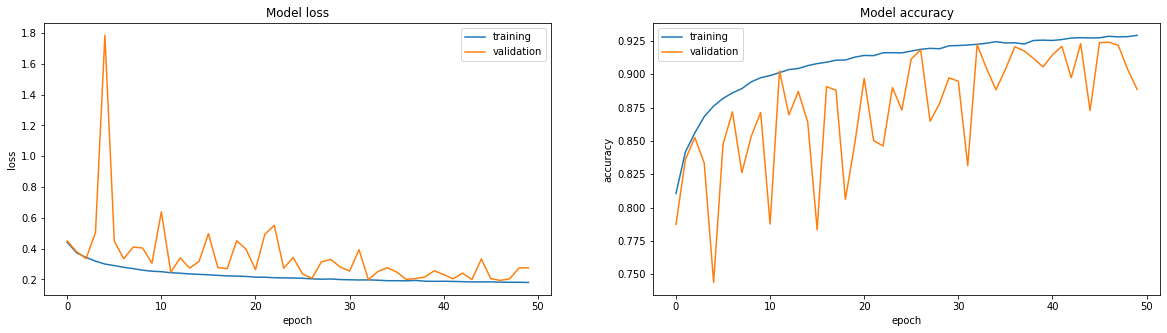

2063/2063 [==============================] - 9s 4ms/step - loss: 0.2753 - accuracy: 0.8886
Validation Accuracy: 0.8886346817016602


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
# added
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
# added
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
# added
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
# added
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=50) 

## 5b: Batch normalization + lower learning rate

Epoch 1/50
4814/4814 [==============================] - 55s 8ms/step - loss: 0.5039 - accuracy: 0.7812 - val_loss: 0.4179 - val_accuracy: 0.8211
Epoch 2/50
4814/4814 [==============================] - 39s 8ms/step - loss: 0.4035 - accuracy: 0.8222 - val_loss: 0.3912 - val_accuracy: 0.8345
Epoch 3/50
4814/4814 [==============================] - 39s 8ms/step - loss: 0.3770 - accuracy: 0.8352 - val_loss: 0.3976 - val_accuracy: 0.8398
Epoch 4/50
4814/4814 [==============================] - 39s 8ms/step - loss: 0.3585 - accuracy: 0.8440 - val_loss: 0.3546 - val_accuracy: 0.8521
Epoch 5/50
4814/4814 [==============================] - 39s 8ms/step - loss: 0.3426 - accuracy: 0.8516 - val_loss: 0.4174 - val_accuracy: 0.8326
Epoch 6/50
4814/4814 [==============================] - 38s 8ms/step - loss: 0.3286 - accuracy: 0.8593 - val_loss: 0.3854 - val_accuracy: 0.8401
Epoch 7/50
4814/4814 [==============================] - 38s 8ms/step - loss: 0.3179 - accuracy: 0.8642 - val_loss: 0.4418 - val_ac

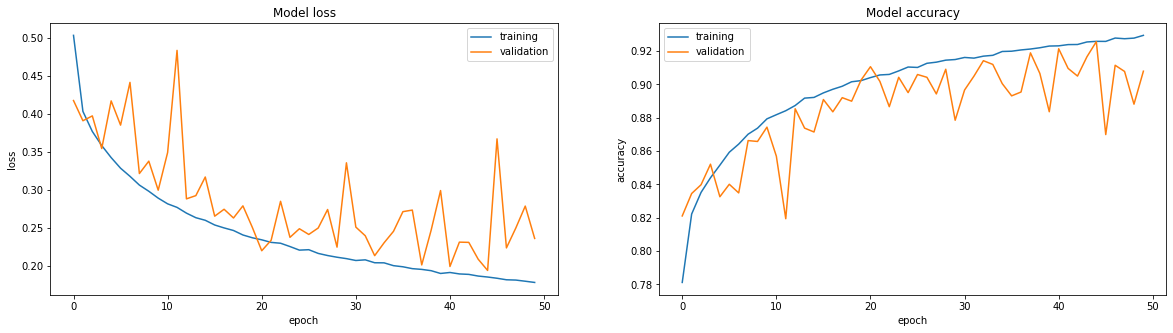

2063/2063 [==============================] - 8s 4ms/step - loss: 0.2359 - accuracy: 0.9079
Validation Accuracy: 0.907935380935669


In [ ]:
# lower learning rate:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=50, l_rate=0.0001) 

Epoch 1/50
4814/4814 [==============================] - 38s 8ms/step - loss: 0.5558 - accuracy: 0.7585 - val_loss: 0.4353 - val_accuracy: 0.8148
Epoch 2/50
4814/4814 [==============================] - 37s 8ms/step - loss: 0.4325 - accuracy: 0.8065 - val_loss: 0.4460 - val_accuracy: 0.8270
Epoch 3/50
4814/4814 [==============================] - 36s 8ms/step - loss: 0.4033 - accuracy: 0.8218 - val_loss: 0.4643 - val_accuracy: 0.8299
Epoch 4/50
4814/4814 [==============================] - 36s 8ms/step - loss: 0.3861 - accuracy: 0.8302 - val_loss: 0.4399 - val_accuracy: 0.8366
Epoch 5/50
4814/4814 [==============================] - 36s 8ms/step - loss: 0.3710 - accuracy: 0.8382 - val_loss: 0.4676 - val_accuracy: 0.8390
Epoch 6/50
4814/4814 [==============================] - 36s 8ms/step - loss: 0.3570 - accuracy: 0.8452 - val_loss: 0.4456 - val_accuracy: 0.8386
Epoch 7/50
4814/4814 [==============================] - 36s 8ms/step - loss: 0.3456 - accuracy: 0.8506 - val_loss: 0.3980 - val_ac

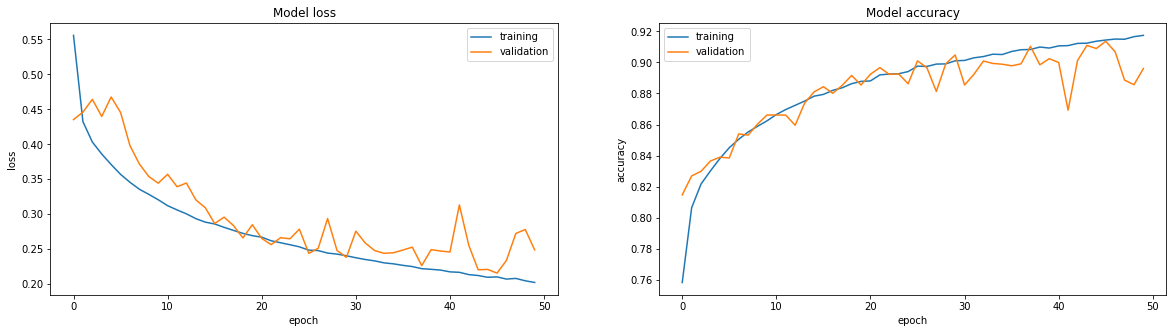

2063/2063 [==============================] - 9s 4ms/step - loss: 0.2490 - accuracy: 0.8961
Validation Accuracy: 0.8960580825805664


In [ ]:
# lower learning rate:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=50, l_rate=0.00005) 

## 5c: Batch normalization + batch size = 10

Epoch 1/40
4814/4814 [==============================] - 38s 8ms/step - loss: 0.4377 - accuracy: 0.8130 - val_loss: 0.3945 - val_accuracy: 0.8234
Epoch 2/40
4814/4814 [==============================] - 37s 8ms/step - loss: 0.3731 - accuracy: 0.8399 - val_loss: 0.4854 - val_accuracy: 0.8122
Epoch 3/40
4814/4814 [==============================] - 37s 8ms/step - loss: 0.3429 - accuracy: 0.8565 - val_loss: 0.4876 - val_accuracy: 0.7580
Epoch 4/40
4814/4814 [==============================] - 37s 8ms/step - loss: 0.3176 - accuracy: 0.8684 - val_loss: 0.3369 - val_accuracy: 0.8586
Epoch 5/40
4814/4814 [==============================] - 37s 8ms/step - loss: 0.3042 - accuracy: 0.8753 - val_loss: 0.5225 - val_accuracy: 0.8281
Epoch 6/40
4814/4814 [==============================] - 37s 8ms/step - loss: 0.2888 - accuracy: 0.8822 - val_loss: 0.4862 - val_accuracy: 0.8169
Epoch 7/40
4814/4814 [==============================] - 37s 8ms/step - loss: 0.2828 - accuracy: 0.8843 - val_loss: 0.4122 - val_ac

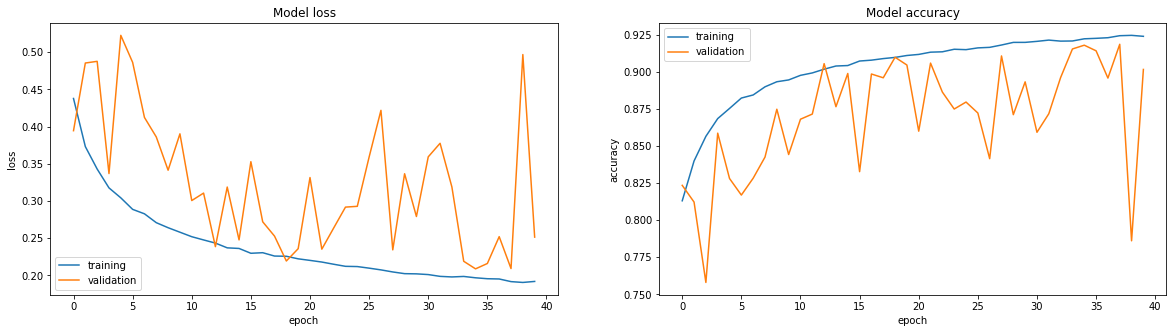

2063/2063 [==============================] - 8s 4ms/step - loss: 0.2515 - accuracy: 0.9015
Validation Accuracy: 0.9015119671821594


In [ ]:
# lower learning rate:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=40, batch_size=10) 

## 5d: Batch normalization + batch size = 50

Epoch 1/40
4814/4814 [==============================] - 43s 9ms/step - loss: 0.4397 - accuracy: 0.8112 - val_loss: 0.3695 - val_accuracy: 0.8414
Epoch 2/40
4814/4814 [==============================] - 42s 9ms/step - loss: 0.3725 - accuracy: 0.8423 - val_loss: 0.4368 - val_accuracy: 0.8114
Epoch 3/40
4814/4814 [==============================] - 41s 8ms/step - loss: 0.3407 - accuracy: 0.8574 - val_loss: 0.3133 - val_accuracy: 0.8655
Epoch 4/40
4814/4814 [==============================] - 39s 8ms/step - loss: 0.3184 - accuracy: 0.8688 - val_loss: 0.4857 - val_accuracy: 0.8081
Epoch 5/40
4814/4814 [==============================] - 39s 8ms/step - loss: 0.3058 - accuracy: 0.8738 - val_loss: 0.3417 - val_accuracy: 0.8582
Epoch 6/40
4814/4814 [==============================] - 39s 8ms/step - loss: 0.2908 - accuracy: 0.8803 - val_loss: 0.3549 - val_accuracy: 0.8541
Epoch 7/40
4814/4814 [==============================] - 39s 8ms/step - loss: 0.2810 - accuracy: 0.8849 - val_loss: 0.6537 - val_ac

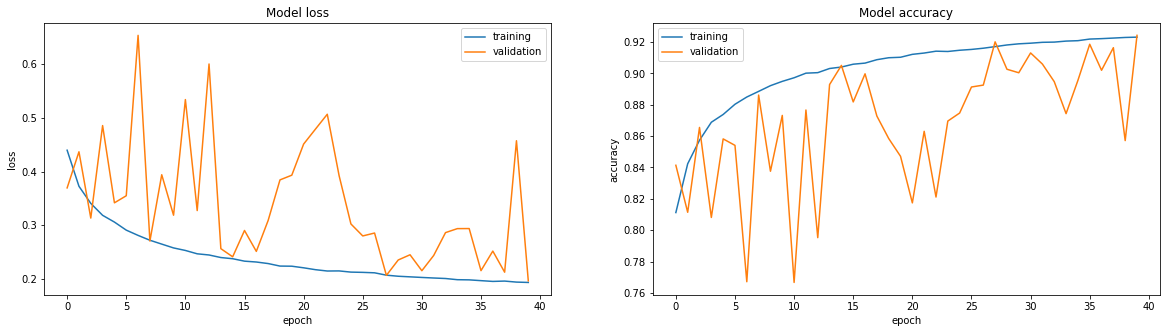

2063/2063 [==============================] - 8s 4ms/step - loss: 0.1963 - accuracy: 0.9242
Validation Accuracy: 0.9242061376571655


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=40, batch_size=50) 

## 5e: Batch normalization + L2 regularization

Epoch 1/40
4814/4814 [==============================] - 38s 8ms/step - loss: 0.7558 - accuracy: 0.8112 - val_loss: 0.5334 - val_accuracy: 0.7855
Epoch 2/40
4814/4814 [==============================] - 38s 8ms/step - loss: 0.4770 - accuracy: 0.8372 - val_loss: 0.8310 - val_accuracy: 0.7402
Epoch 3/40
4814/4814 [==============================] - 38s 8ms/step - loss: 0.4418 - accuracy: 0.8503 - val_loss: 0.4973 - val_accuracy: 0.8262
Epoch 4/40
4814/4814 [==============================] - 39s 8ms/step - loss: 0.4046 - accuracy: 0.8588 - val_loss: 0.4117 - val_accuracy: 0.8460
Epoch 5/40
4814/4814 [==============================] - 38s 8ms/step - loss: 0.3814 - accuracy: 0.8652 - val_loss: 1.0776 - val_accuracy: 0.7259
Epoch 6/40
4814/4814 [==============================] - 38s 8ms/step - loss: 0.3680 - accuracy: 0.8690 - val_loss: 1.5211 - val_accuracy: 0.6961
Epoch 7/40
4814/4814 [==============================] - 38s 8ms/step - loss: 0.3612 - accuracy: 0.8705 - val_loss: 0.3672 - val_ac

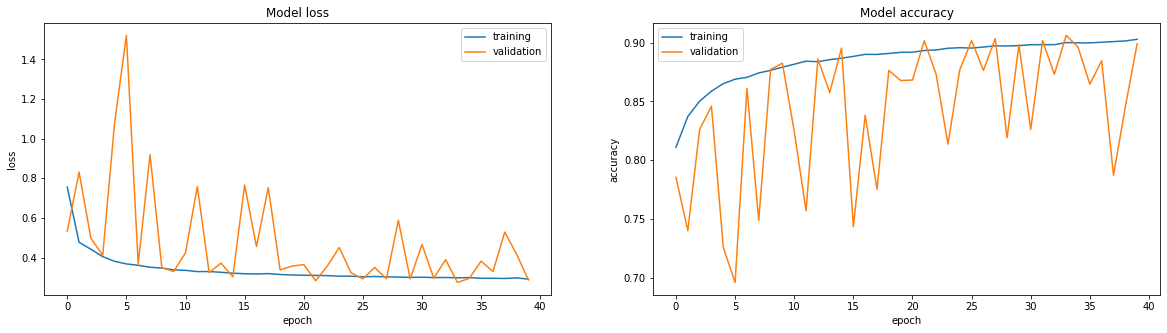

2063/2063 [==============================] - 8s 4ms/step - loss: 0.2872 - accuracy: 0.8991
Validation Accuracy: 0.8990879654884338


In [ ]:
# L2
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer='l2', bias_regularizer='l2'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu', kernel_regularizer='l2', bias_regularizer='l2'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax', kernel_regularizer='l2', bias_regularizer='l2'))

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=40) 

try:
l 2 reg
batch size 10, 50, 100

**Analysis of the graph above:**

Adding batch normalization does seem to stabilize the traing accuracy as expected. The validation accuracy, however, still fluctuates a lot. How to solve this?

# Model 6: Data augmentation

Probably useful: 


Experimental:
width and height shift range

## 6a: Horizontal and vertical flip

Epoch 1/70
4814/4814 [==============================] - 69s 14ms/step - loss: 0.4368 - accuracy: 0.8126 - val_loss: 0.3788 - val_accuracy: 0.8310
Epoch 2/70
4814/4814 [==============================] - 64s 13ms/step - loss: 0.3782 - accuracy: 0.8397 - val_loss: 0.7610 - val_accuracy: 0.6998
Epoch 3/70
4814/4814 [==============================] - 61s 13ms/step - loss: 0.3490 - accuracy: 0.8537 - val_loss: 1.4384 - val_accuracy: 0.6364
Epoch 4/70
4814/4814 [==============================] - 62s 13ms/step - loss: 0.3304 - accuracy: 0.8627 - val_loss: 0.5078 - val_accuracy: 0.7924
Epoch 5/70
4814/4814 [==============================] - 64s 13ms/step - loss: 0.3155 - accuracy: 0.8700 - val_loss: 0.8481 - val_accuracy: 0.7394
Epoch 6/70
4814/4814 [==============================] - 72s 15ms/step - loss: 0.3029 - accuracy: 0.8757 - val_loss: 0.2973 - val_accuracy: 0.8774
Epoch 7/70
4814/4814 [==============================] - 63s 13ms/step - loss: 0.2934 - accuracy: 0.8794 - val_loss: 1.6732 -

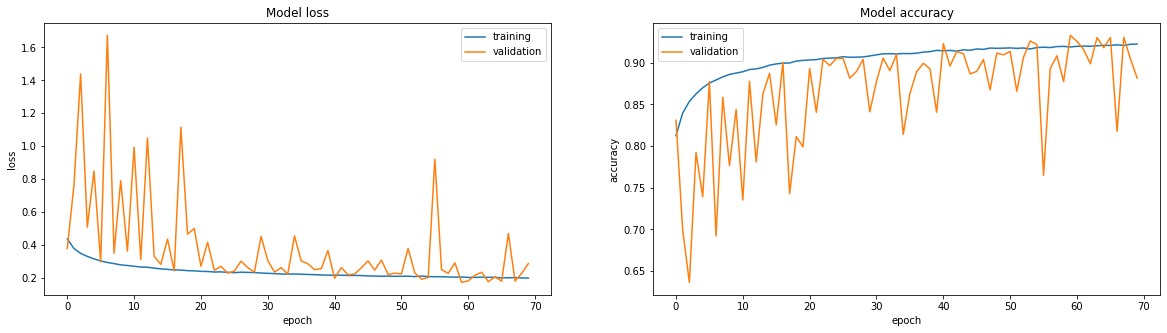

2063/2063 [==============================] - 9s 4ms/step - loss: 0.2873 - accuracy: 0.8817
Validation Accuracy: 0.8817264437675476


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())


model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

aug = {'horizontal_flip': True, 
       'vertical_flip': True}

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, augment=aug, epochs=60) 

## 6a.a: Horizontal and vertical flip + higher dropout

Epoch 1/60
4814/4814 [==============================] - 68s 7ms/step - loss: 0.4480 - accuracy: 0.8096 - val_loss: 0.4029 - val_accuracy: 0.8272
Epoch 2/60
4814/4814 [==============================] - 36s 7ms/step - loss: 0.3833 - accuracy: 0.8367 - val_loss: 0.6727 - val_accuracy: 0.7052
Epoch 3/60
4814/4814 [==============================] - 36s 7ms/step - loss: 0.3593 - accuracy: 0.8484 - val_loss: 0.3930 - val_accuracy: 0.8142
Epoch 4/60
4814/4814 [==============================] - 36s 7ms/step - loss: 0.3421 - accuracy: 0.8556 - val_loss: 0.3931 - val_accuracy: 0.8294
Epoch 5/60
4814/4814 [==============================] - 36s 7ms/step - loss: 0.3273 - accuracy: 0.8642 - val_loss: 0.4110 - val_accuracy: 0.8140
Epoch 6/60
4814/4814 [==============================] - 36s 7ms/step - loss: 0.3150 - accuracy: 0.8694 - val_loss: 0.3278 - val_accuracy: 0.8483
Epoch 7/60
4814/4814 [==============================] - 36s 7ms/step - loss: 0.3035 - accuracy: 0.8743 - val_loss: 0.3962 - val_ac

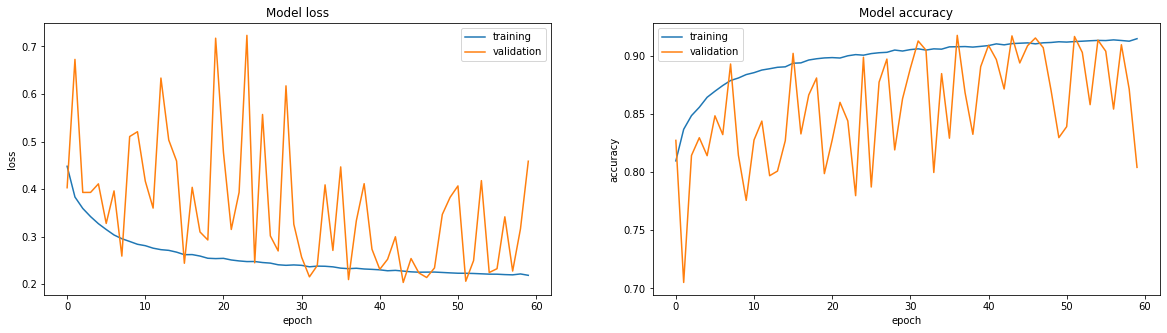

2063/2063 [==============================] - 8s 4ms/step - loss: 0.4587 - accuracy: 0.8040
Validation Accuracy: 0.8039783239364624


In [ ]:
# higher dropout
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())


model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

aug = {'horizontal_flip': True, 
       'vertical_flip': True}

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, augment=aug, epochs=60) 

In [ ]:
## 6a.b: Horizontal and vertical flip + larger batch-size

Epoch 1/40
4814/4814 [==============================] - 112s 17ms/step - loss: 0.4396 - accuracy: 0.8095 - val_loss: 0.3860 - val_accuracy: 0.8270
Epoch 2/40
4814/4814 [==============================] - 69s 14ms/step - loss: 0.3741 - accuracy: 0.8404 - val_loss: 0.8738 - val_accuracy: 0.6876
Epoch 3/40
4814/4814 [==============================] - 73s 15ms/step - loss: 0.3471 - accuracy: 0.8546 - val_loss: 1.2363 - val_accuracy: 0.6293
Epoch 4/40
4814/4814 [==============================] - 71s 15ms/step - loss: 0.3241 - accuracy: 0.8646 - val_loss: 0.3471 - val_accuracy: 0.8522
Epoch 5/40
4814/4814 [==============================] - 73s 15ms/step - loss: 0.3111 - accuracy: 0.8708 - val_loss: 0.4072 - val_accuracy: 0.8402
Epoch 6/40
4814/4814 [==============================] - 71s 15ms/step - loss: 0.2996 - accuracy: 0.8759 - val_loss: 0.3248 - val_accuracy: 0.8611
Epoch 7/40
4814/4814 [==============================] - 72s 15ms/step - loss: 0.2898 - accuracy: 0.8813 - val_loss: 0.2674 

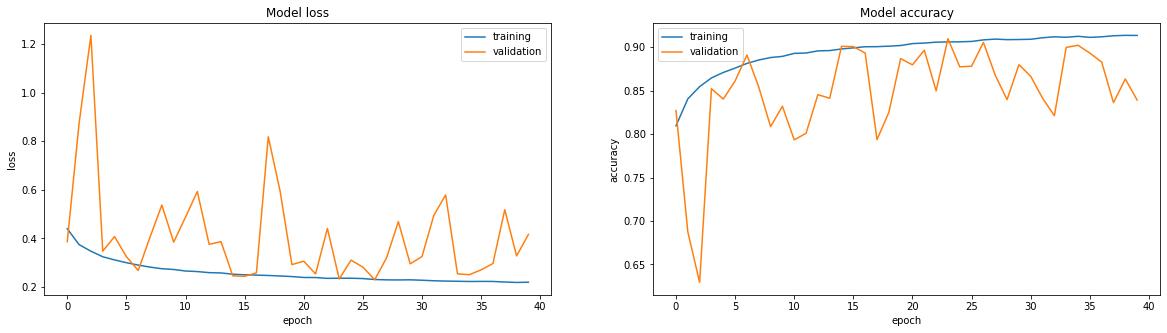

2063/2063 [==============================] - 13s 6ms/step - loss: 0.4161 - accuracy: 0.8391
Validation Accuracy: 0.8390649557113647


In [ ]:
# batchsize larger
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())


model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

aug = {'horizontal_flip': True, 
       'vertical_flip': True}

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, augment=aug, epochs=40, batch_size=10) 

## 6b: Horizontal and vertical flip and zoom

Epoch 1/60
4814/4814 [==============================] - 112s 17ms/step - loss: 0.4758 - accuracy: 0.7891 - val_loss: 0.3881 - val_accuracy: 0.8295
Epoch 2/60
4814/4814 [==============================] - 81s 17ms/step - loss: 0.4016 - accuracy: 0.8260 - val_loss: 0.6354 - val_accuracy: 0.7207
Epoch 3/60
4814/4814 [==============================] - 81s 17ms/step - loss: 0.3699 - accuracy: 0.8421 - val_loss: 0.5745 - val_accuracy: 0.7775
Epoch 4/60
4814/4814 [==============================] - 80s 17ms/step - loss: 0.3497 - accuracy: 0.8513 - val_loss: 0.4318 - val_accuracy: 0.8238
Epoch 5/60
4814/4814 [==============================] - 80s 17ms/step - loss: 0.3364 - accuracy: 0.8574 - val_loss: 0.5691 - val_accuracy: 0.7838
Epoch 6/60
4814/4814 [==============================] - 80s 17ms/step - loss: 0.3229 - accuracy: 0.8642 - val_loss: 0.4540 - val_accuracy: 0.7701
Epoch 7/60
4814/4814 [==============================] - 79s 16ms/step - loss: 0.3138 - accuracy: 0.8680 - val_loss: 0.6923 

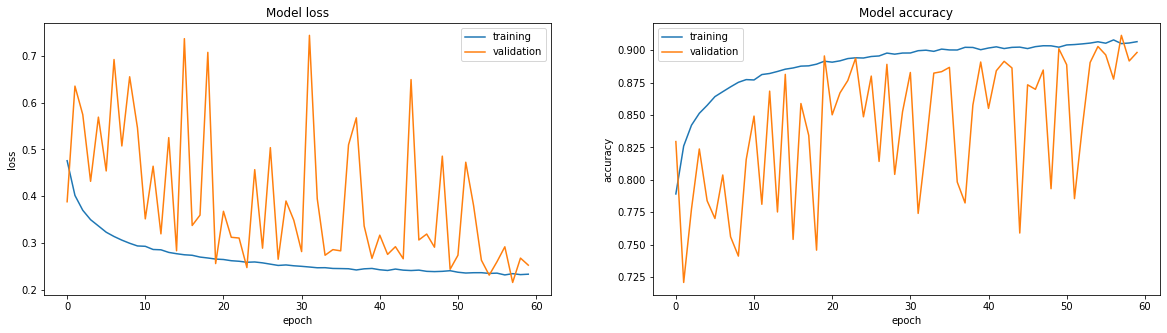

2063/2063 [==============================] - 8s 4ms/step - loss: 0.2525 - accuracy: 0.8983
Validation Accuracy: 0.8983002305030823


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())


model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

aug = {'horizontal_flip': True, 
       'vertical_flip': True, 
       'zoom_range': 0.1}

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, augment=aug, epochs=60) 

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())


model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(2, activation='softmax'))

aug = {'horizontal_flip': True, 
       'vertical_flip': True, 
       'zoom_range': 0.1, 
       'rotation_range': 20}

train_and_evaluate(model, train_images, train_labels, val_images, val_labels, preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, augment=aug, epochs=60) 

In [ ]:
aug = {'horizontal_flip': True, 
       'vertical_flip': True, 
       'zoom_range': 0.1, 
       'rotation_range': 20, 
       'width_shift_range': 0.1, 
       'height_shift_range': 0.1,}

augmentation?
k-fold?


false positives minder erg dan false negatives?

In [ ]:
# define the frame
x1, y1 = 32, 32
x2, y2 = 64, 64

cropped = image[1:(y2 + 1), 1:(x2 + 1)]